In [1]:
import pandas as pd
import os

# Load the CSV
df = pd.read_csv("data.csv")

# Check the content
print("First 5 rows:")
print(df.head())

# Check if files exist
print("\nFile existence check:")
df['file_exists'] = df['filepath'].apply(lambda x: os.path.exists(x))
print(df[['filepath', 'file_exists']])

# Check for missing labels
print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique labels:", df['label'].unique())


First 5 rows:
                                            filepath     label
0  D:\projects\Big Projects\AD detection\dementia...  dementia
1  D:\projects\Big Projects\AD detection\dementia...  dementia
2  D:\projects\Big Projects\AD detection\dementia...  dementia
3  D:\projects\Big Projects\AD detection\dementia...  dementia
4  D:\projects\Big Projects\AD detection\dementia...  dementia

File existence check:
                                              filepath  file_exists
0    D:\projects\Big Projects\AD detection\dementia...         True
1    D:\projects\Big Projects\AD detection\dementia...         True
2    D:\projects\Big Projects\AD detection\dementia...         True
3    D:\projects\Big Projects\AD detection\dementia...         True
4    D:\projects\Big Projects\AD detection\dementia...         True
..                                                 ...          ...
217  D:\projects\Big Projects\AD detection\nodement...         True
218  D:\projects\Big Projects\AD detectio

c:\Users\Acer\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Acer\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Acer\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Audio loaded successfully: (441000,), Sample rate: 44100


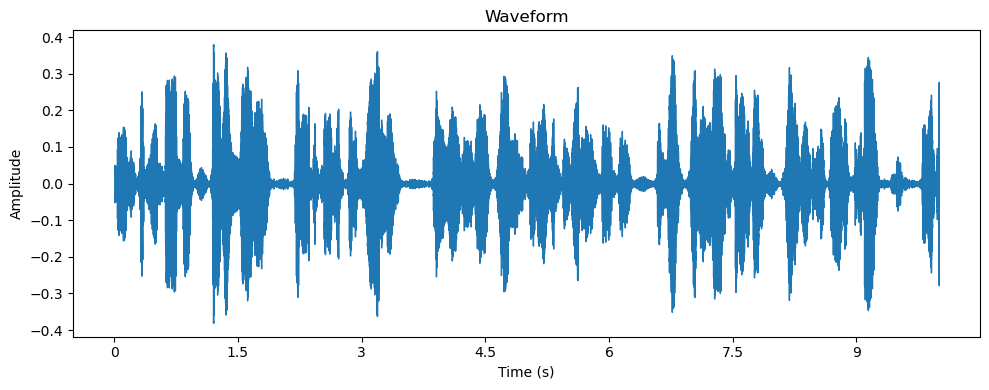

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

file_path = r"dementia\Abe Burrows\AbeBurrows_5.wav"

# Force use of audioread by skipping soundfile (done implicitly if soundfile fails)
y, sr = librosa.load(file_path, sr=None, mono=True, duration=10.0)

print(f"Audio loaded successfully: {y.shape}, Sample rate: {sr}")

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import librosa

def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)

        # --- 1. Mel-Spectrogram ---
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # --- 2. Acoustic Features ---
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mel = np.mean(log_mel_spectrogram.T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

        # Combine acoustic features into one vector
        acoustic_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])

        return log_mel_spectrogram, acoustic_features

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, None


In [4]:
#test 
spec, acoustic = extract_features(r"dementia\Abe Burrows\AbeBurrows_5.wav")

print("Mel-Spectrogram shape:", spec.shape)
print("Acoustic feature vector shape:", acoustic.shape)


Mel-Spectrogram shape: (128, 6118)
Acoustic feature vector shape: (193,)


In [5]:
import os
import numpy as np
import librosa

cnn_data = []
cnn_labels = []

mlp_data = []
mlp_labels = []

# No need for full path since you're already in the correct directory
categories = {
    "dementia": 1,
    "nodementia": 0
}

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        log_mel_spec = librosa.power_to_db(mel_spec)

        # Statistical features (mean, std) for MLP
        mean = np.mean(log_mel_spec, axis=1)
        std = np.std(log_mel_spec, axis=1)
        features = np.concatenate((mean, std))

        return log_mel_spec, features

    except Exception as e:
        print("Failed to process:", file_path)
        print("Reason:", e)
        return None, None

for category in categories:
    label = categories[category]
    category_path = os.path.join(os.getcwd(), category)  # Use current directory

    for speaker in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker)

        if os.path.isdir(speaker_path):
            for file in os.listdir(speaker_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(speaker_path, file)
                    print("Processing:", file_path)

                    spec, features = extract_features(file_path)

                    if spec is not None and features is not None:
                        padded_spec = librosa.util.fix_length(spec, size=862, axis=1)
                        cnn_data.append(padded_spec)
                        cnn_labels.append(label)

                        mlp_data.append(features)
                        mlp_labels.append(label)

# Convert to NumPy arrays
X_cnn = np.array(cnn_data)
y_cnn = np.array(cnn_labels)

X_mlp = np.array(mlp_data)
y_mlp = np.array(mlp_labels)

print("CNN input shape:", X_cnn.shape)
print("MLP input shape:", X_mlp.shape)


Processing: d:\projects\Big Projects\AD detection\dementia\Abe Burrows\AbeBurrows_5.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Aileen Hernandez\aileenhernandez_0.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Aileen Hernandez\aileenhernandez_5_1.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Aileen Hernandez\aileenhernandez_5_2.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Alan Ramsey\alanramsey_10.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Allan Burns\AllanBurns_5.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Andrew Sachs\andrewsachs_10.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Andrew Sachs\andrewsachs_15.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Annette Michelson\annettemichelson_15.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Antony Flew\antonyflew_10.wav
Processing: d:\projects\Big Projects\AD detection\dementia\Antony

In [6]:
import os
print("Current working directory:", os.getcwd())


Current working directory: d:\projects\Big Projects\AD detection


In [7]:
from sklearn.model_selection import train_test_split

# For CNN, add channel dimension (needed for Conv2D)
X_cnn = X_cnn[..., np.newaxis]  # Shape: (222, 128, 862, 1)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)


In [9]:
pip install tensorflow --timeout=1000 --no-cache-dir


   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/376.0 MB 1.7 MB/s eta 0:03:45
   ---------------------------------------- 1.0/376.0 MB 2.1 MB/s eta 0:02:59
   ---------------------------------------- 1.6/376.0 MB 2.3 MB/s eta 0:02:46
   ---------------------------------------- 2.1/376.0 MB 2.1 MB/s eta 0:02:56
   ---------------------------------------- 2.4/376.0 MB 2.2 MB/s eta 0:02:53
   ---------------------------------------- 2.9/376.0 MB 2.1 MB/s eta 0:02:58
   ---------------------------------------- 2.9/376.0 MB 2.1 MB/s eta 0:02:58
   ---------------------------------------- 3.1/376.0 MB 1.9 MB/s eta 0:03:14
   ---------------------------------------- 3.4/376.0 MB 1.8 MB/s eta 0:03:28
   ---------------------------------------- 3.7/376.0 MB 1.7 MB/s eta 0:03:41
   ---------------------------------------- 3.9/376.0 MB 1.6 MB/s eta 0:03:52


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 862, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


c:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 860, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 428, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 214, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 410880)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    26,296,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,315,265 (100.38 MB)

 Trainable params: 26,315,265 (100.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
mlp_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(256,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.summary()


c:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,217 (161.00 KB)

 Trainable params: 41,217 (161.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cnn_model.fit(X_cnn_train, y_cnn_train, epochs=20, batch_size=16, validation_split=0.1)
mlp_model.fit(X_mlp_train, y_mlp_train, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 831ms/step - accuracy: 0.4888 - loss: 355.3591 - val_accuracy: 0.6667 - val_loss: 14.3541
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.5499 - loss: 16.3040 - val_accuracy: 0.3333 - val_loss: 1.2038
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - accuracy: 0.5468 - loss: 0.7050 - val_accuracy: 0.6667 - val_loss: 0.6618
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step - accuracy: 0.5897 - loss: 0.6668 - val_accuracy: 0.6667 - val_loss: 0.6879
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - accuracy: 0.6630 - loss: 0.6659 - val_accuracy: 0.6111 - val_loss: 0.6881
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 731ms/step - accuracy: 0.7588 - loss: 0.6073 - val_accuracy: 0.6667 - val_loss: 0.6673
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - accuracy: 0.7820 - loss: 0.4899 - val_accuracy: 0.5556 - val_loss: 0.7205
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 764ms/step - accuracy: 0.7867 - loss: 0.4135 - val_accuracy

In [13]:
cnn_eval = cnn_model.evaluate(X_cnn_test, y_cnn_test)
mlp_eval = mlp_model.evaluate(X_mlp_test, y_mlp_test)

print(f"✅ CNN Test Accuracy: {cnn_eval[1]*100:.2f}%")
print(f"✅ MLP Test Accuracy: {mlp_eval[1]*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4674 - loss: 1.8941
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4970 - loss: 0.6622
✅ CNN Test Accuracy: 46.67%
✅ MLP Test Accuracy: 51.11%


In [14]:
from collections import Counter
print(Counter(y_cnn))
print(Counter(y_mlp))


Counter({1: 131, 0: 91})
Counter({1: 131, 0: 91})


In [15]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_cnn),
    y=y_cnn
)

class_weights_dict = dict(enumerate(class_weights))


In [18]:
cnn_model.fit(
    X_cnn_train, y_cnn_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights_dict
)

mlp_model.fit(
    X_mlp_train, y_mlp_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights_dict
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 813ms/step - accuracy: 0.9928 - loss: 0.0316 - val_accuracy: 0.3889 - val_loss: 2.4976
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 830ms/step - accuracy: 0.9563 - loss: 0.0619 - val_accuracy: 0.5000 - val_loss: 2.2117
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.2778 - val_loss: 2.6585
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - accuracy: 0.9783 - loss: 0.0348 - val_accuracy: 0.3333 - val_loss: 2.5579
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - accuracy: 0.9913 - loss: 0.0326 - val_accuracy: 0.3889 - val_loss: 2.4077
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 755ms/step - accuracy: 0.9982 - loss: 0.0227 - val_accuracy: 0.4444 - val_loss: 2.4743
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.4444 - val_loss: 2.8097
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.

In [21]:
cnn_eval = cnn_model.evaluate(X_cnn_test, y_cnn_test)
mlp_eval = mlp_model.evaluate(X_mlp_test, y_mlp_test)

print(f"✅ CNN Test Accuracy: {cnn_eval[1]*100:.2f}%")
print(f"✅ MLP Test Accuracy: {mlp_eval[1]*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4273 - loss: 2.7672
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5623 - loss: 0.6705
✅ CNN Test Accuracy: 42.22%
✅ MLP Test Accuracy: 57.78%


In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_mlp_balanced, y_mlp_balanced = sm.fit_resample(X_mlp, y_mlp)


In [24]:
from imblearn.over_sampling import RandomOverSampler

X_cnn_flat = X_cnn.reshape(X_cnn.shape[0], -1)  # flatten for oversampling
ros = RandomOverSampler()
X_cnn_resampled, y_cnn_resampled = ros.fit_resample(X_cnn_flat, y_cnn)

# Reshape back to original CNN shape
X_cnn_resampled = X_cnn_resampled.reshape(-1, 128, 862, 1)


In [26]:
from sklearn.model_selection import train_test_split

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
    X_cnn_resampled, y_cnn_resampled, test_size=0.2, random_state=42, stratify=y_cnn_resampled
)


In [27]:
cnn_model.fit(
    X_cnn_train, y_cnn_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 797ms/step - accuracy: 0.8703 - loss: 0.5505 - val_accuracy: 0.6667 - val_loss: 0.5563
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - accuracy: 0.9255 - loss: 0.3703 - val_accuracy: 0.7143 - val_loss: 0.5083
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - accuracy: 0.9272 - loss: 0.2227 - val_accuracy: 0.6667 - val_loss: 0.7293
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 700ms/step - accuracy: 0.9534 - loss: 0.1120 - val_accuracy: 0.7619 - val_loss: 0.7595
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 789ms/step - accuracy: 0.9810 - loss: 0.0694 - val_accuracy: 0.6667 - val_loss: 0.8073
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - accuracy: 0.9800 - loss: 0.0473 - val_accuracy: 0.7143 - val_loss: 0.9163
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/step - accuracy: 0.9924 - loss: 0.0273 - val_accuracy: 0.6667 - val_loss: 1.1485
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step - accuracy: 0.9777 - loss: 0.0473 - val_accuracy: 0

In [28]:
cnn_eval = cnn_model.evaluate(X_cnn_test, y_cnn_test)
print(f"✅ CNN Test Accuracy After Balancing: {cnn_eval[1]*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9644 - loss: 0.2313
✅ CNN Test Accuracy After Balancing: 96.23%


In [29]:
from collections import Counter
print("Balanced y_cnn:", Counter(y_cnn_resampled))


Balanced y_cnn: Counter({1: 131, 0: 131})


In [35]:
# Save the model
cnn_model.save("final_cnn_alzheimer_model.h5")


In [39]:
X_cnn_train.shape

(209, 128, 862, 1)

In [33]:
pip install sounddevice librosa

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array
from scipy.io import wavfile
import os

# Load trained model
model = load_model("D:/projects/Big Projects/AD detection/final_cnn_alzheimer_model.h5")

def preprocess_audio(file_path, target_shape=(128, 862)):
    y, sr = librosa.load(file_path, sr=22050)
    
    # Generate mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Resize or pad to match training input
    if mel_spec_db.shape[1] < target_shape[1]:
        pad_width = target_shape[1] - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :target_shape[1]]

    mel_spec_db = mel_spec_db.reshape(target_shape[0], target_shape[1], 1)
    mel_spec_db = mel_spec_db / 255.0  # Normalize if you did that during training
    return np.expand_dims(mel_spec_db, axis=0)  # Add batch dimension

# Upload audio file (manually upload for now)
file_path = "D:/projects/Big Projects/AD detection/test_audio2.wav"  # Replace with your test audio

# Preprocess and predict
input_data = preprocess_audio(file_path)
prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

# Result
classes = ['Not Alzheimer', 'Alzheimer']  # Modify according to your labels
print(f"🧠 Predicted Class: {classes[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🧠 Predicted Class: Not Alzheimer


## Multimodal Model: CNN (Audio) + LSTM (Transcript)


In [1]:
import pandas as pd

# Load the updated CSV
df = pd.read_csv("data_with_transcripts.csv")  # replace with your actual file name

# Preview
print(df.head())

# Optional: Drop missing transcripts if any
df = df.dropna(subset=['transcript'])


                                            filepath     label  \
0  D:\projects\Big Projects\AD detection\dementia...  dementia   
1  D:\projects\Big Projects\AD detection\dementia...  dementia   
2  D:\projects\Big Projects\AD detection\dementia...  dementia   
3  D:\projects\Big Projects\AD detection\dementia...  dementia   
4  D:\projects\Big Projects\AD detection\dementia...  dementia   

                                          transcript  
0   He was worried when I became a performer. He ...  
1   This is not going to sound like very ladylike...  
2   I arrive at my first political science class....  
3   We are more conscious in this state now about...  
4   I have no real love for the two leaders. I th...  


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 0 → dementia, 1 → non_dementia (depending on your dataset)


In [4]:
!pip install transformers --quiet


In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [7]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

MAX_LEN = 128

for transcript in df['transcript']:
    encoded = tokenizer.encode_plus(
        transcript,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'  # if you're using TensorFlow, else use 'pt' for PyTorch
    )
    input_ids.append(encoded['input_ids'].squeeze(0))
    attention_masks.append(encoded['attention_mask'].squeeze(0))

# Convert to NumPy arrays
input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)


In [8]:
import numpy as np

X_text = np.array(input_ids)
X_mask = np.array(attention_masks)
y = np.array(df['label_encoded'])

print("X_text shape:", X_text.shape)
print("X_mask shape:", X_mask.shape)
print("y shape:", y.shape)


X_text shape: (222, 128)
X_mask shape: (222, 128)
y shape: (222,)


In [10]:
pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
    --------------------------------------- 2.9/216.1 MB 10.5 MB/s eta 0:00:21
    --------------------------------------- 5.0/216.1 MB 10.4 MB/s eta 0:00:21
   - -------------------------------------- 5.5/216.1 MB 9.1 MB/s eta 0:00:24
   - -------------------------------------- 5.8/216.1 MB 7.7 MB/s eta 0:00:28
   - -------------------------------------- 6.3/216.1 MB 5.8 MB/s eta 0:00:36
   - -------------------------------------- 6.6/216.1 MB 5.2 MB/s eta 0:00:41
   - -------------------------------------- 6.8/216.1 MB 4.7 MB/s eta 0:00:45
   - -------------------------------------- 7.1/216.1 MB 4.4 MB/s eta 0:00:48
   - -------------------------------------- 7.3/216.1 MB 4.0 MB/s eta 0:00:52
   - -------------------------------------- 7.6/216.1 MB 3.9 MB/s eta 0:00:55
   - ---------

In [12]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import numpy as np


In [13]:
# Example: dataframe with two columns - 'transcript' and 'label'
df = pd.read_csv("data_with_transcripts.csv")  # Replace with your file

# Optional: encode labels if not numeric
df['label'] = df['label'].astype(int)

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['transcript'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


ValueError: invalid literal for int() with base 10: 'dementia'

In [14]:
print(df['label'].unique())


['dementia' 'nodementia']


In [15]:
# Step 1: Map string labels to integers
label_mapping = {
    'dementia': 1,
    'nodementia': 0
}
df['label'] = df['label'].map(label_mapping)

# Step 2: Drop any rows where mapping failed (just in case)
df = df.dropna(subset=['label'])

# Step 3: Convert to integer (should work now)
df['label'] = df['label'].astype(int)


In [21]:
pip install datasets


Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load your cleaned data
df = pd.read_csv("data_with_transcripts.csv")

# Label encoding
df['label'] = df['label'].map({'nodementia': 0, 'dementia': 1})

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['transcript'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# Prepare Dataset objects
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Using device: cpu


Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [24]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.7.1+cpu
False


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-dementia-output",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)

# Metric function
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFBertForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.
